In [67]:
%schedule --create

SCHEDULE_CREATE: Required Parameters - User Guide 
 For Cornerstone Users 
 
 
Prepend hdfs:/// when specifying file name in ML Tools. For e.g.
 
 Before: /axp/platform/mlplat/dev/file.txt 
 After: hdfs:///axp/platform/mlplat/dev/file.txt 
 
 
 
Always use absolute file path when
referring to a file in ML Tools.
 
 
Refer /adshome/ location as hdfs:///idn/home/ 
 
 
 
 

 





 

 
 
 

start_date

 
 
 
 Start date of the schedule. Date should be in UTC Timezone 
 


 
 
 


 
 
 





 
 
 

start_time

 
 
 
 Start time of the Schedule. Time should be in UTC Timezone 
 


 
 
 


 
 
 


 




 

 
 
 

end_date

 
 
 
 End date of the Schedule. Date should be in UTC Timezone 
 


 
 
 


 
 
 





 
 
 

end_time

 
 
 
 End time of the Schedule. Time should be in UTC Timezone 
 


 
 
 


 
 
 


 




 

 
 
 

repeat_frequency

 
 
 
 Repeat frequency of the Schedule 
 


 
 


 DAY 

 WEEK-DAY 


 



 
 
 





 
 
 

repeat_value

 
 
 
 Value for the repeat frequency 
 


 



 
 
 


 




 

 
 
 

output_path

 
 
 
 Output Path where the output notebook will be written back on periodic basis. 
 


 



 
 
 





 

 


 
 
 
 Run

In [73]:
# SCHEDULE_CREATE : SCHEDULE Output

2023-02-21 22:10:44,016 - root.mdk - ERROR - invalid syntax (<string>, line 7)


2023-02-21 22:10:44,017 - root.mdk - ERROR - invalid syntax (<string>, line 7)


In [1]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import time, os, sys, glob
import smtplib
import re
import email
import email.mime
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
import matplotlib.pyplot as plt
from datetime import date
from calendar import monthrange
from datetime import datetime, timedelta 
from datetime import datetime, timedelta

from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as F
from pyspark.sql.types import DateType, StringType, LongType
from pyspark.sql.functions import to_date, to_timestamp
from pyspark.sql.types import StructField, StructType, StringType
from pyspark.sql.window import Window
sns.set()

from docx import Document
from docx.shared import Inches, Cm, Pt
from docx.enum.style import WD_STYLE_TYPE

In [2]:
os.environ['SPARK_HOME']='/opt/mapr/spark/spark'
os.environ['PYSPARK_PYTHON']='/opt/python/python35/bin/python'
spark_python = os.path.join(os.environ.get('SPARK_HOME', None), 'python')
py4j = glob.glob(os.path.join(spark_python, 'lib', 'py4j-*.zip'))[0]
sys.path[:0]=[spark_python, py4j]
os.environ['PYTHONPATH']=py4j

In [3]:
sqlContext = SparkSession \
        .builder \
        .appName("Test") \
        .enableHiveSupport() \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.executor.cores", "5") \
        .config("spark.executor.instances", "29") \
        .config("spark.executor.memory", "18G") \
        .config("spark.driver.memory", "18G") \
        .config("spark.speculation", "true") \
        .config("spark.sql.parquet.binaryAsString", "true") \
        .config("spark.master", "yarn") \
        .config("spark.driver.allowMultipleContexts", "true") \
        .config("spark.sql.parquet.writeLegacyFormat","true") \
        .config("spark.sql.parquet.writeLegacyFormat","true") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.enabled", "true") \
        .config("spark.blacklist.enabled","false") \
        .config("spark.blacklist.task.maxTaskAttemptsPerExecutor","1") \
        .config("spark.blacklist.task.maxTaskAttemptsPerNode","2") \
        .config("spark.blacklist.application.maxFailedTasksPerExecutor","2") \
        .config("spark.blacklist.stage.maxFailedTasksPerExecutor","2") \
        .config("spark.blacklist.application.maxFailedExecutorsPerNode","2") \
        .config("spark.blacklist.stage.maxFailedExecutorsPerNode","2") \
        .config("spark.blacklist.timeout","1h") \
        .config("spark.sql.broadcastTimeout", "1h") \
        .config("spark.blacklist.killBlacklistedExecutors","true") \
        .config("spark.sql.autoBroadcastJoinThreshold" "2000Mb") \
        .config("spark.task.maxDirectResultSize", "2Gb") \
        .enableHiveSupport() \
        .getOrCreate()
sc = sqlContext.sparkContext
sqlContext = SQLContext(sc)

In [4]:
sc.version

'2.4.4.502-mapr-636'

#### Reading the Datasets for MGM Int'l

In [5]:
overall_funnel = sqlContext.sql("SELECT * FROM yash_mgm_intl.overall_funnel")
row, col = overall_funnel.count(), len(overall_funnel.columns)

print("DataFrame Shape: ({}, {})".format(row, col))
#print(overall_funnel.printSchema())
#overall_funnel.show(1, vertical=True)

DataFrame Shape: (636916, 28)


Check to run the code only if the tabs are of the latest refresh

In [5]:
# Path to the file/directory
path = "/axp/buanalytics/csacqins/warehouse/yjain6/yash_mgm_intl.db/overall_funnel"

ti_c = os.path.getctime(path)
ti_m = os.path.getmtime(path)
 
creation_time_cur = time.ctime(ti_c)
modified_time_cur = time.ctime(ti_m)
 
print(f"The file located at the path {path} \
was created at {creation_time_cur} ({ti_c}) and was "
      f"last modified at {modified_time_cur}")

The file located at the path /axp/buanalytics/csacqins/warehouse/yjain6/yash_mgm_intl.db/overall_funnel was created at Tue Feb  7 10:26:41 2023 (1675790801.7501) and was last modified at Tue Feb  7 10:26:40 2023


In [3]:
############################
ti_c_prev = 1675790801.7501
############################
if ti_c>ti_c_prev:
    print("The dataset is of the latest refresh. Hence, executing the QC Script")
else:
    print("The tabs haven't been refreshed yet! Aborting the script!")
    sys.exit()

The tabs haven't been refreshed yet! Aborting the script!


SystemExit: 

In [8]:
overall_funnel_df = overall_funnel.toPandas()
pd.options.display.max_columns = 1000
overall_funnel_df.head(2)

,market,year,month,period,week,asset,product,prod_bu,device,exp_type,mgmer_visitor,mgmer_visits,mgmer_referral_start,mgmer_referral_start_people,referral,referrer,mgmer_referral_submit_email,mgmer_referral_submit_copylink,mgmer_referral_submit_facebook,mgmer_referral_submit_linkedin,mgmee_visitor,mgmee_visits,app_start,submit,decisioned,approved,cancel,decline
0,AUSTRALIA,2021,JAN,2021-01,W02_14Jan21,APP,Cons GRCC David Jones Gold,CONS,Desktop,Not Logged In,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1
1,AUSTRALIA,2021,JAN,2021-01,W03_21Jan21,APP,Cons GRCC David Jones Gold,CONS,Desktop,Not Logged In,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0


In [9]:
#overall_funnel_trunc = overall_funnel.filter(overall_funnel.year.isin(2022,2023))
#overall_funnel_df = overall_funnel_trunc.toPandas()
#pd.options.display.max_columns = 1000
#overall_funnel_df.head(2)

In [10]:
ts = str(int(time.time())) 

home_dir = "/axp/buanalytics/csacqins/dev/tanisha/mgm_intl/" 
filename = "qc_report_trends"+ ts +".docx" 
fileloc = home_dir + "qc/" 
import docx
document = docx.Document()
sections = document.sections
for section in sections:
    section.top_margin = Cm(2)
    section.bottom_margin = Cm(2)
    section.left_margin = Cm(2)
    section.right_margin = Cm(2)

obj_styles = document.styles
obj_charstyle = obj_styles.add_style('Head', WD_STYLE_TYPE.CHARACTER)
obj_font = obj_charstyle.font
obj_font.size = Pt(16)
obj_font.name = "Guardian Egyp Regular"

document.add_heading('DATA QUALITY CHECK', 0)#document.add_heading(level=0).add_run(, style="Head")
records = (
    ('Market Cross BU Trends',''),
    ('1.','MGMer Visitors - Top Volume Driving Markets Cross Cons BU'),
    ('2.','MGMer Visitors - Medium Volume Driving Markets Cross Cons BU'),
    ('3.','MGMer Visitors - Low Volume Driving Markets Cross Cons BU'),
    ('4.','Referrer Rate - Top Volume Driving Markets Cross Cons BU'),
    ('5.','Referrer Rate - Medium Volume Driving Markets Cross Cons BU'),
    ('6.','Referrer Rate - Low Volume Driving Markets Cross Cons BU'),
    ('7.','NAA Rate- Top Volume Driving Markets Cross Cons BU'),
    ('8.','NAA Rate- Medium Volume Driving Markets Cross Cons BU'),
    ('9.','NAA Rate- Low Volume Driving Markets Cross Cons BU'),
    ('10.','MGMer Visitors - Top Volume Driving Markets Cross SBS BU'),
    ('11.','MGMer Visitors - Medium Volume Driving Markets Cross SBS BU'),
    ('12.','MGMer Visitors - Low Volume Driving Markets Cross SBS BU'),
    ('13.','Referrer Rate - Top Volume Driving Markets Cross SBS BU'),
    ('14.','Referrer Rate - Medium Volume Driving Markets Cross SBS BU'),
    ('15.','Referrer Rate - Low Volume Driving Markets Cross SBS BU'),
    ('16.','NAA Rate- Top Volume Driving Markets Cross SBS BU'),
    ('17.','NAA Rate- Medium Volume Driving Markets Cross SBS BU'),
    ('18.','NAA Rate- Low Volume Driving Markets Cross SBS BU'),

    ('Market Cross Asset Trends',''),
    ('19.','MGMer Visitors - Top Volume Driving Markets Cross Hub'),
    ('20.','MGMer Visitors - Medium Volume Driving Markets Cross Hub'),
    ('21.','MGMer Visitors - Low Volume Driving Markets Cross Hub'),
    ('22.','Referrer Rate - Top Volume Driving Markets Cross Hub'),
    ('23.','Referrer Rate - Medium Volume Driving Markets Cross Hub'),
    ('24.','Referrer Rate - Low Volume Driving Markets Cross Hub'),
    ('25.','NAA Rate- Top Volume Driving Markets Cross Hub'),
    ('26.','NAA Rate- Medium Volume Driving Markets Cross Hub'),
    ('27.','NAA Rate- Low Volume Driving Markets Cross Hub'),
    ('28.','MGMer Visitors - Top Volume Driving Markets Cross APP'),
    ('29.','MGMer Visitors - Medium Volume Driving Markets Cross APP'),
    ('30.','MGMer Visitors - Low Volume Driving Markets Cross APP'),
    ('31.','Referrer Rate - Top Volume Driving Markets Cross APP'),
    ('32.','Referrer Rate - Medium Volume Driving Markets Cross APP'),
    ('33.','Referrer Rate - Low Volume Driving Markets Cross APP'),
    ('34.','NAA Rate- Top Volume Driving Markets Cross APP'),
    ('35.','NAA Rate- Medium Volume Driving Markets Cross APP'),
    ('36.','NAA Rate- Low Volume Driving Markets Cross APP'),
    ('37.','MGMer Visitors - Top Volume Driving Markets Cross MYCA Widget'),
    ('38.','MGMer Visitors - Medium Volume Driving Markets Cross MYCA Widget'),
    ('39.','MGMer Visitors - Low Volume Driving Markets Cross MYCA Widget'),
    ('40.','Referrer Rate - Top Volume Driving Markets Cross MYCA Widget'),
    ('41.','Referrer Rate - Medium Volume Driving Markets Cross MYCA Widget'),
    ('42.','Referrer Rate - Low Volume Driving Markets Cross MYCA Widget'),
    ('43.','NAA Rate- Top Volume Driving Markets Cross MYCA Widget'),
    ('44.','NAA Rate- Medium Volume Driving Markets Cross MYCA Widget'),
    ('45.','NAA Rate- Low Volume Driving Markets Cross MYCA Widget')
)
table = document.add_table(rows=1, cols=2)
row = table.rows[0].cells
row[0].text = 'Id'
row[1].text = 'Metric'
for id, metric in records:
    row = table.add_row().cells
    row[0].text = str(id)
    row[1].text = metric
table.style = 'Colorful List'
document.add_page_break()
doc_para = document.add_paragraph('Please note that: ')
doc_para.add_run('Top Volume Driving Markets includes UK').bold = True
doc_para.add_run(',')
doc_para.add_run('  Medium Volume Driving Markets include Canada, Australia, Japan, Mexico, Germany').bold = True
doc_para.add_run(' and ')
doc_para.add_run('Low Volume Driving Markets include Italy, France, Sweden, Netherlands, Hong Kong, Singapore, Spain').bold = True
#doc_para.add_run('these words are italic').italic = True
#document.add_page_break()
#document.add_heading(level=1).add_run('Overall KPI Trend', style="Head")
print("Data Quality Check & Anomaly Detection results will be exported to \"{}\" location at \"{}\" ".format(filename, fileloc))

Data Quality Check & Anomaly Detection results will be exported to "qc_report_trends1677039202.docx" location at "/axp/buanalytics/csacqins/dev/tanisha/mgm_intl/qc/" 


Excluding 'All Makets' column value since it is a sum of all the markets; 14 mkts for Cons & 5 mkts for SBS

In [11]:
overall_funnel_df = overall_funnel_df[overall_funnel_df['market']!='ALL MARKETS']
overall_funnel_df['mgmer_referral_submit_total'] = overall_funnel_df['mgmer_referral_submit_email']+overall_funnel_df['mgmer_referral_submit_copylink']+overall_funnel_df['mgmer_referral_submit_facebook']+overall_funnel_df['mgmer_referral_submit_linkedin']

overall_funnel_df['year'] = overall_funnel_df['period'].str[:4]
overall_funnel_df['week'] = overall_funnel_df['week'].str[:3]
overall_funnel_df = overall_funnel_df.sort_values(by = ["year","week"])

In [12]:
overall_funnel_df.columns

Index(['market', 'year', 'month', 'period', 'week', 'asset', 'product',
       'prod_bu', 'device', 'exp_type', 'mgmer_visitor', 'mgmer_visits',
       'mgmer_referral_start', 'mgmer_referral_start_people', 'referral',
       'referrer', 'mgmer_referral_submit_email',
       'mgmer_referral_submit_copylink', 'mgmer_referral_submit_facebook',
       'mgmer_referral_submit_linkedin', 'mgmee_visitor', 'mgmee_visits',
       'app_start', 'submit', 'decisioned', 'approved', 'cancel', 'decline',
       'mgmer_referral_submit_total'],
      dtype='object')

Annualizing the absolute KPIs for week number 99 

In [13]:
overall_funnel_df['week_num'] = overall_funnel_df['week'].str[1:].astype('int')

In [14]:
overall_funnel_df['mgmer_visitor'] = np.where(overall_funnel_df['week_num']>53,overall_funnel_df['mgmer_visitor']*7,overall_funnel_df['mgmer_visitor'])
overall_funnel_df['referrer'] = np.where(overall_funnel_df['week_num']>53,overall_funnel_df['referrer']*7,overall_funnel_df['referrer'])
overall_funnel_df['approved'] = np.where(overall_funnel_df['week_num']>53,overall_funnel_df['approved']*7,overall_funnel_df['approved'])
overall_funnel_df['mgmer_visits'] = np.where(overall_funnel_df['week_num']>53,overall_funnel_df['mgmer_visits']*7,overall_funnel_df['mgmer_visits'])
overall_funnel_df['mgmee_visitor'] = np.where(overall_funnel_df['week_num']>53,overall_funnel_df['mgmee_visitor']*7,overall_funnel_df['mgmee_visitor'])

Annualizing the absolute KPIs for week_num number 0 

In [15]:
overall_funnel_df['mgmer_visitor'] = np.where(overall_funnel_df['week_num']<1,overall_funnel_df['mgmer_visitor']*7,overall_funnel_df['mgmer_visitor'])
overall_funnel_df['referrer'] = np.where(overall_funnel_df['week_num']<1,overall_funnel_df['referrer']*7,overall_funnel_df['referrer'])
overall_funnel_df['approved'] = np.where(overall_funnel_df['week_num']<1,overall_funnel_df['approved']*7,overall_funnel_df['approved'])
overall_funnel_df['mgmer_visits'] = np.where(overall_funnel_df['week_num']<1,overall_funnel_df['mgmer_visits']*7,overall_funnel_df['mgmer_visits'])
overall_funnel_df['mgmee_visitor'] = np.where(overall_funnel_df['week_num']<1,overall_funnel_df['mgmee_visitor']*7,overall_funnel_df['mgmee_visitor'])

## Market Cross BU

In [16]:
document.add_heading(level=1).add_run('Segmentized KPI Trend - Market Cross BU', style="Head")

In [17]:
def seg_func(table,col):
    table["SMA"]         =table[col].rolling(12).mean()
    table["Upper Band"] = table["SMA"] + 1.5*(table[col].rolling(12).std())
    table["Lower Band"] = table["SMA"] - 1.5*(table[col].rolling(12).std())
    df = table
    def get_signal(df,col):
        low_signal = []
        high_signal = []
        for i in range(len(table[col])):
            if table[col][i]>table["Upper Band"][i]:
                low_signal.append(np.nan)
                high_signal.append(table[col][i])
            elif table[col][i]<table["Lower Band"][i]:
                high_signal.append(np.nan)
                low_signal.append(table[col][i])
            else:
                high_signal.append(np.nan)
                low_signal.append(np.nan)
        return (low_signal, high_signal)
    df['Low'] = get_signal(df,col)[0]
    df['High'] =get_signal(df,col)[1]
    table['week']  = table['year'].astype(str) + '_' + table['week'].astype(str)  
    table = table.set_index('week')
    fig = plt.figure(figsize=(20,3))
    x_axis = table.index
    ax = fig.add_subplot(1,1,1)
    ax.fill_between(x_axis, table["Upper Band"], table["Lower Band"], color='silver')
    ax.plot(x_axis, table["Lower Band"])
    ax.plot(x_axis, table[col], color='blue')
    ax.plot(x_axis, table["SMA"], color='orange')
    ax.scatter(x_axis, table['Low'], color = 'red', marker='^')
    ax.scatter(x_axis, table['High'], color = 'green', marker='^')
    plt.xticks(rotation= 90)
    
    return table, col

### CONS

In [18]:
mkt_df = overall_funnel_df.groupby(["year","week","market","prod_bu"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()
mkt_df = mkt_df[mkt_df['prod_bu']=='CONS']
mkt_df['referrer_rate'] =    mkt_df['referrer']/ mkt_df['mgmer_visitor']
mkt_df['naa_rate'] =  mkt_df['approved']/ mkt_df['mgmer_visits']

top_mkt_df = mkt_df[mkt_df['market']=='UK'].reset_index(drop=True)

mid_mkt_df = mkt_df[mkt_df.market.isin(['CANADA','AUSTRALIA','JAPAN','MEXICO','GERMANY'])].reset_index(drop=True)
mid_mkt_df = mid_mkt_df.groupby(["year","week","prod_bu"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

mid_mkt_df['referrer_rate'] =    mid_mkt_df['referrer']/ mid_mkt_df['mgmer_visitor']
mid_mkt_df['naa_rate'] =         mid_mkt_df['approved']/ mid_mkt_df['mgmer_visits']

low_mkt_df = mkt_df[mkt_df.market.isin(['ITALY','FRANCE','SWEDEN','NETHERLANDS','HONG KONG','SINGAPORE','SPAIN'])].reset_index(drop=True)
low_mkt_df = low_mkt_df.groupby(["year","week","prod_bu"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

low_mkt_df['referrer_rate'] =   low_mkt_df['referrer']/ low_mkt_df['mgmer_visitor']
low_mkt_df['naa_rate'] =        low_mkt_df['approved']/ low_mkt_df['mgmer_visits']

### Top Markets Cross CONS

In [19]:
#document.add_heading(level=4).add_run('Top Volume Driving Market - UK', style="Head")

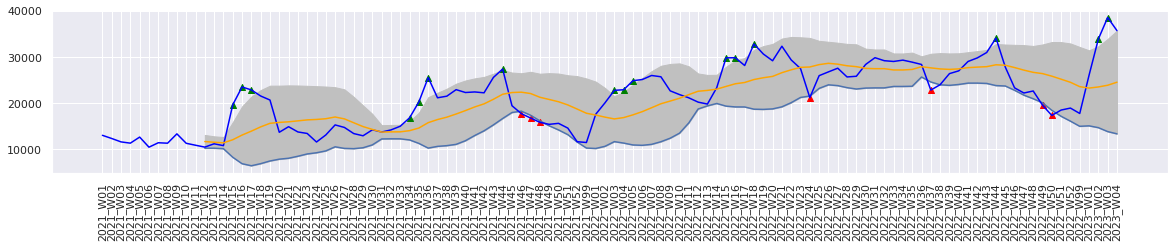

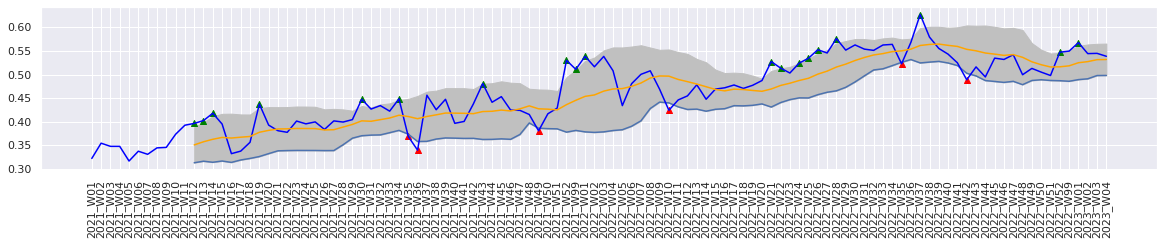

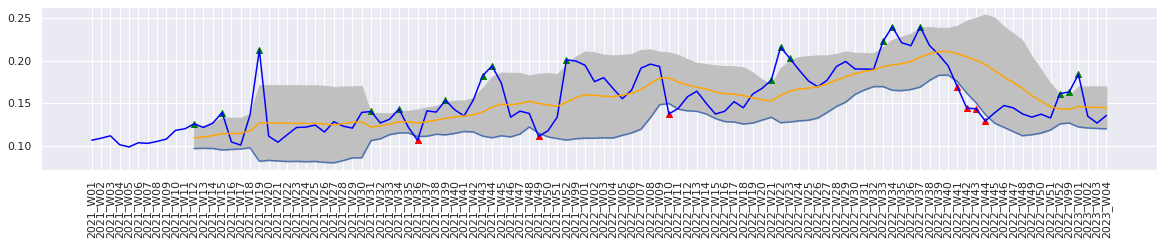

In [20]:
table = pd.pivot_table(data=top_mkt_df, values=['mgmer_visitor'], index=['year','week',"prod_bu"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'mgmer_visitor', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Top Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Top Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic17.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic17.png', width=Inches(7), height=Inches(2))
    plt.show()
    
table = pd.pivot_table(data=top_mkt_df, values=['referrer_rate'], index=['year','week',"prod_bu"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'referrer_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Top Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Top Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic16.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic16.png', width=Inches(7), height=Inches(2))
    plt.show()

table = pd.pivot_table(data=top_mkt_df, values=['naa_rate'], index=['year','week',"prod_bu"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'naa_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For NAA Rate - Top Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Top Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic18.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic18.png', width=Inches(7), height=Inches(2))
    plt.show()

### Medium Markets Cross CONS

In [21]:
#document.add_heading(level=4).add_run('Medium Volume Driving Markets - CANADA,AUSTRALIA,JAPAN,MEXICO,GERMANY', style="Head")

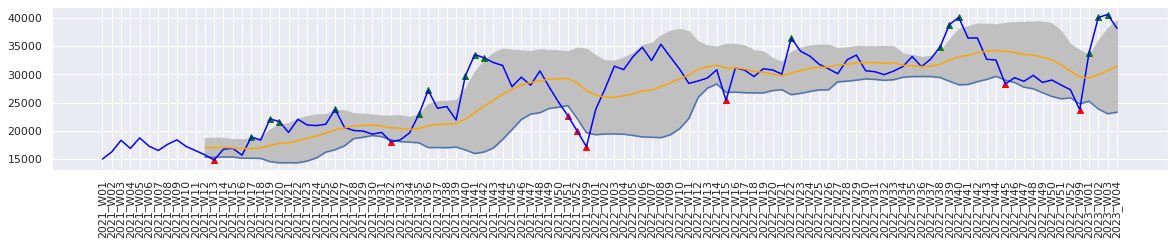

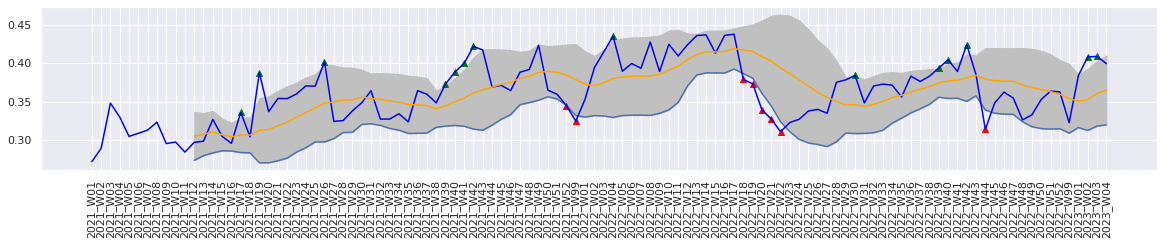

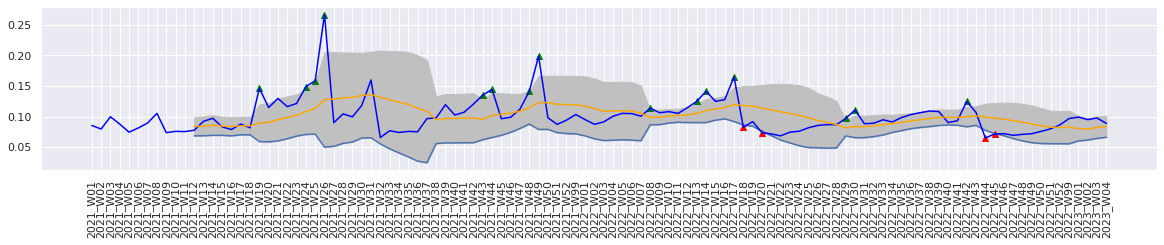

In [22]:
table = pd.pivot_table(data=mid_mkt_df, values=['mgmer_visitor'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Medium Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Medium Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic24.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic24.png', width=Inches(7), height=Inches(2))
    plt.show()
    
table = pd.pivot_table(data=mid_mkt_df, values=['referrer_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Medium Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Medium Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic23.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic23.png', width=Inches(7), height=Inches(2))
    plt.show()

table = pd.pivot_table(data=mid_mkt_df, values=['naa_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Medium Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Medium Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic25.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic25.png', width=Inches(7), height=Inches(2))
    plt.show()

### Low Markets Cross CONS

In [23]:
#document.add_heading(level=4).add_run('Low Volume Driving Markets - ITALY,FRANCE,SWEDEN,NETHERLANDS,HONG KONG,SINGAPORE,SPAIN', style="Head")

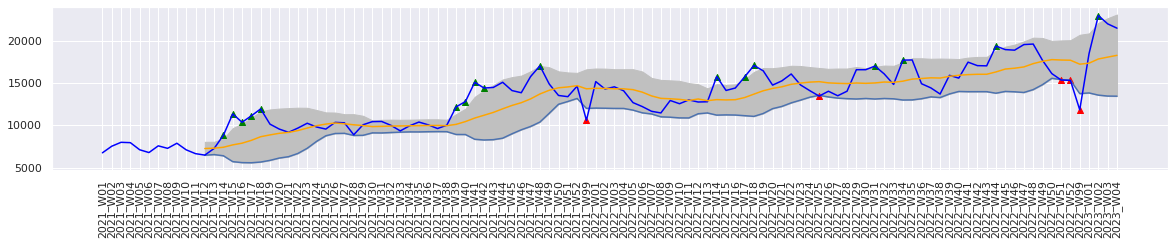

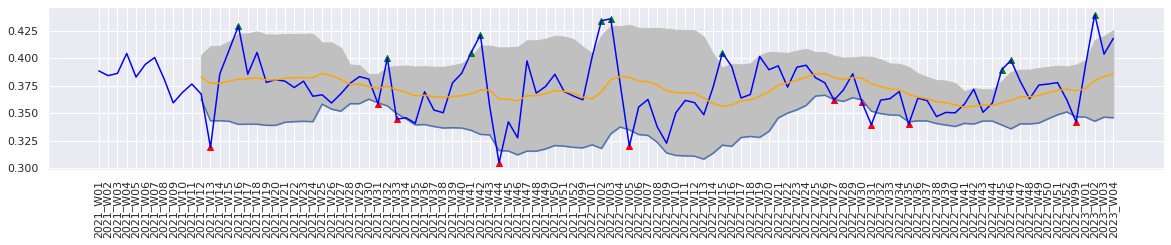

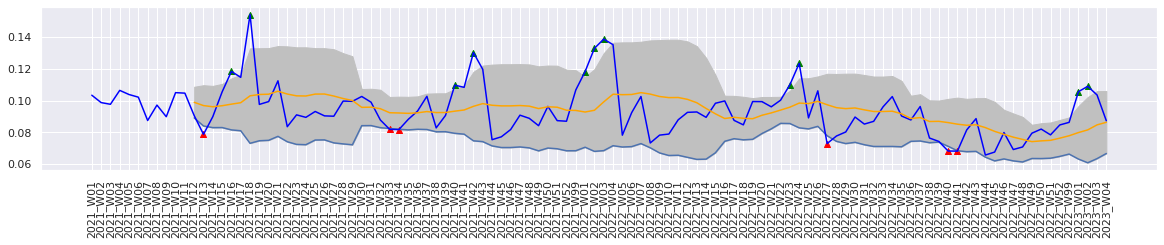

In [24]:
table = pd.pivot_table(data=low_mkt_df, values=['mgmer_visitor'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Low Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Low Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic31.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic31.png', width=Inches(7), height=Inches(2))
    plt.show()

table = pd.pivot_table(data=low_mkt_df, values=['referrer_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Low Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Low Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic30.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic30.png', width=Inches(7), height=Inches(2))
    plt.show()

table = pd.pivot_table(data=low_mkt_df, values=['naa_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Low Volume Driving Markets Cross CONS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Low Volume Driving Markets Cross CONS BU")
    plt.savefig(fileloc + 'pic32.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic32.png', width=Inches(7), height=Inches(2))
    plt.show()

### SBS

In [25]:
mkt_df = overall_funnel_df.groupby(["year","week","market","prod_bu"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()
mkt_df = mkt_df[mkt_df['prod_bu']=='SBS']
mkt_df['referrer_rate'] =    mkt_df['referrer']/ mkt_df['mgmer_visitor']
mkt_df['naa_rate'] =  mkt_df['approved']/ mkt_df['mgmer_visits']

top_mkt_df = mkt_df[mkt_df['market']=='UK'].reset_index(drop=True)

mid_mkt_df = mkt_df[mkt_df.market.isin(['CANADA','AUSTRALIA','JAPAN','MEXICO','GERMANY'])].reset_index(drop=True)
mid_mkt_df = mid_mkt_df.groupby(["year","week","prod_bu"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

mid_mkt_df['referrer_rate'] =    mid_mkt_df['referrer']/ mid_mkt_df['mgmer_visitor']
mid_mkt_df['naa_rate'] =         mid_mkt_df['approved']/ mid_mkt_df['mgmer_visits']

low_mkt_df = mkt_df[mkt_df.market.isin(['ITALY','FRANCE','SWEDEN','NETHERLANDS','HONG KONG','SINGAPORE','SPAIN'])].reset_index(drop=True)
low_mkt_df = low_mkt_df.groupby(["year","week","prod_bu"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

low_mkt_df['referrer_rate'] =   low_mkt_df['referrer']/ low_mkt_df['mgmer_visitor']
low_mkt_df['naa_rate'] =        low_mkt_df['approved']/ low_mkt_df['mgmer_visits']

### Top Markets Cross SBS

In [26]:
#document.add_heading(level=4).add_run('Top Volume Driving Market - UK', style="Head")

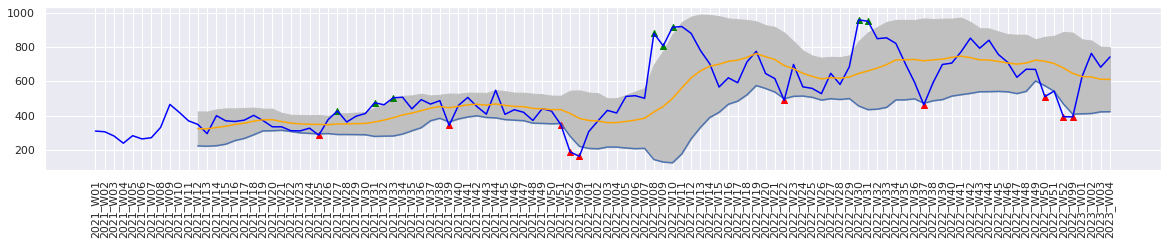

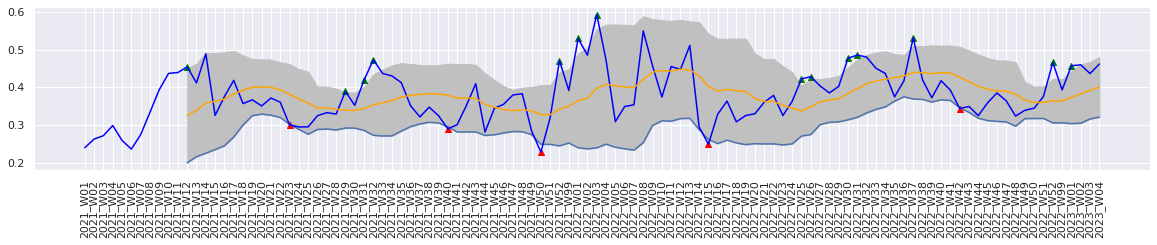

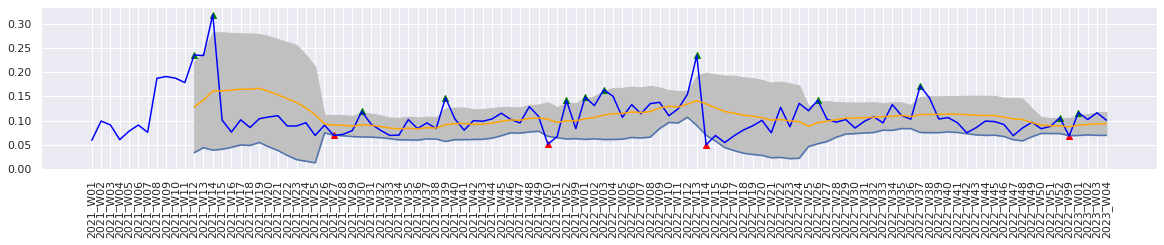

In [27]:
table = pd.pivot_table(data=top_mkt_df, values=['mgmer_visitor'], index=['year','week',"prod_bu"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'mgmer_visitor', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Top Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Top Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic34.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic34.png', width=Inches(7), height=Inches(2))
    plt.show()

table = pd.pivot_table(data=top_mkt_df, values=['referrer_rate'], index=['year','week',"prod_bu"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'referrer_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Top Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Top Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic33.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic33.png', width=Inches(7), height=Inches(2))
    plt.show()

table = pd.pivot_table(data=top_mkt_df, values=['naa_rate'], index=['year','week',"prod_bu"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'naa_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For NAA Rate - Top Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Top Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic35.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic35.png', width=Inches(7), height=Inches(2))
    plt.show()


### Medium Markets Cross SBS

In [28]:
#document.add_heading(level=4).add_run('Medium Volume Driving Markets - CANADA,AUSTRALIA,JAPAN,MEXICO,GERMANY', style="Head")

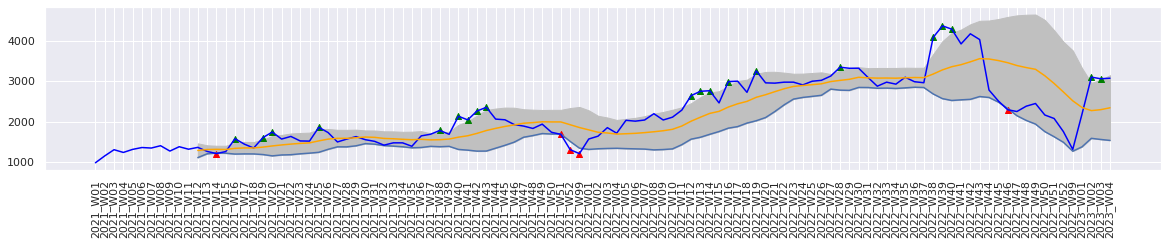

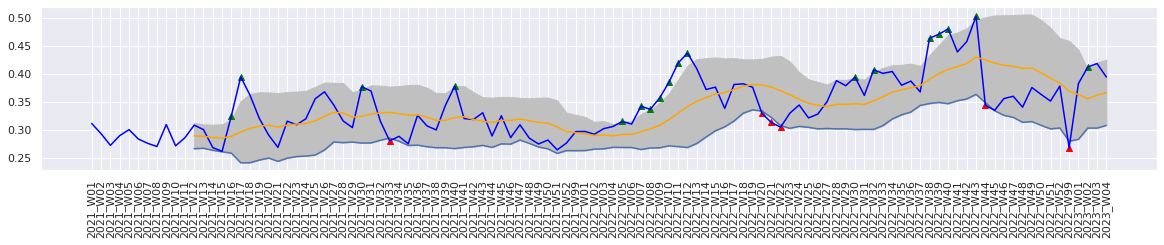

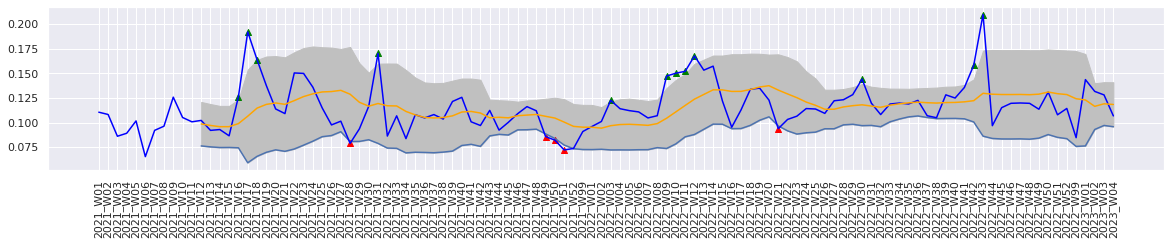

In [29]:
table = pd.pivot_table(data=mid_mkt_df, values=['mgmer_visitor'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Medium Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Medium Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic37.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic37.png', width=Inches(7), height=Inches(2))
    plt.show()

table = pd.pivot_table(data=mid_mkt_df, values=['referrer_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Medium Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Medium Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic36.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic36.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=mid_mkt_df, values=['naa_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Medium Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Medium Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic38.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic38.png', width=Inches(7), height=Inches(2))
    plt.show()

### Low Markets Cross SBS

In [30]:
#document.add_heading(level=4).add_run('Low Volume Driving Markets - ITALY,FRANCE,SWEDEN,NETHERLANDS,HONG KONG,SINGAPORE,SPAIN', style="Head")

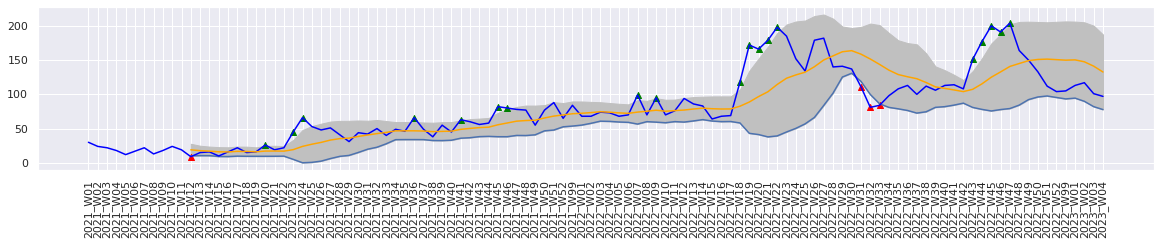

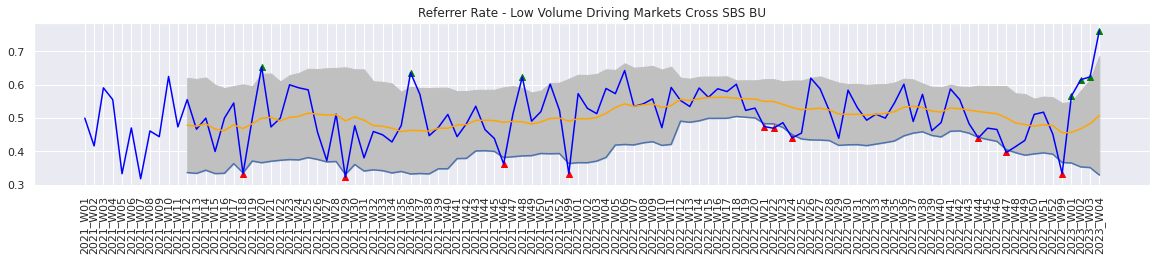

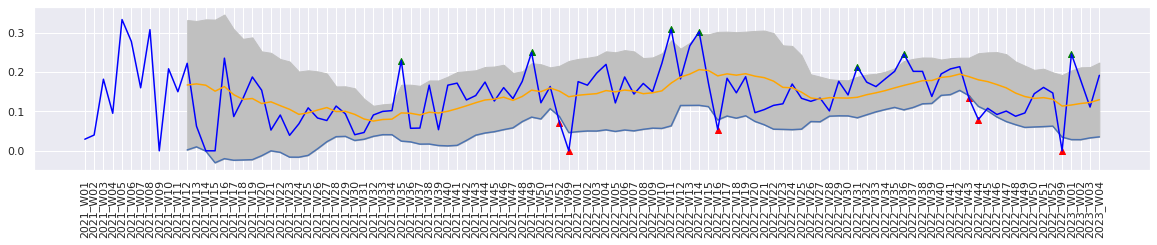

In [31]:
table = pd.pivot_table(data=low_mkt_df, values=['mgmer_visitor'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Low Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Low Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic40.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic40.png', width=Inches(7), height=Inches(2))
    plt.show()
    
table = pd.pivot_table(data=low_mkt_df, values=['referrer_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Low Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Low Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic39.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic39.png', width=Inches(7), height=Inches(2))
    plt.show()
    
table = pd.pivot_table(data=low_mkt_df, values=['naa_rate'], index=['year','week',"prod_bu"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Low Volume Driving Markets Cross SBS BU, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Low Volume Driving Markets Cross SBS BU")
    plt.savefig(fileloc + 'pic41.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic41.png', width=Inches(7), height=Inches(2))
    plt.show()

In [32]:
table

,year,prod_bu,naa_rate,SMA,Upper Band,Lower Band,Low,High
week,,,,,,,,
2021_W01,2021,SBS,0.029412,NaN,NaN,NaN,NaN,NaN
2021_W02,2021,SBS,0.040000,NaN,NaN,NaN,NaN,NaN
2021_W03,2021,SBS,0.181818,NaN,NaN,NaN,NaN,NaN
2021_W04,2021,SBS,0.095238,NaN,NaN,NaN,NaN,NaN
2021_W05,2021,SBS,0.333333,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2022_W99,2022,SBS,0.000000,0.113629,0.192503,0.034755,0.0,NaN
2023_W01,2023,SBS,0.245902,0.116315,0.204262,0.028367,NaN,0.245902
2023_W02,2023,SBS,0.178862,0.120144,0.212028,0.028260,NaN,NaN


## Market Cross Asset

In [33]:
document.add_heading(level=1).add_run('Segmentized KPI Trend - Market Cross Asset', style="Head")

### Hub

In [34]:
mkt_df = overall_funnel_df.groupby(["year","week","market","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()
mkt_df = mkt_df[mkt_df['asset']=='Hub']
mkt_df['referrer_rate'] =    mkt_df['referrer']/ mkt_df['mgmer_visitor']
mkt_df['naa_rate'] =  mkt_df['approved']/ mkt_df['mgmer_visits']

top_mkt_df = mkt_df[mkt_df['market']=='UK'].reset_index(drop=True)

mid_mkt_df = mkt_df[mkt_df.market.isin(['CANADA','AUSTRALIA','JAPAN','MEXICO','GERMANY'])].reset_index(drop=True)
mid_mkt_df = mid_mkt_df.groupby(["year","week","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

mid_mkt_df['referrer_rate'] =    mid_mkt_df['referrer']/ mid_mkt_df['mgmer_visitor']
mid_mkt_df['naa_rate'] =         mid_mkt_df['approved']/ mid_mkt_df['mgmer_visits']

low_mkt_df = mkt_df[mkt_df.market.isin(['ITALY','FRANCE','SWEDEN','NETHERLANDS','HONG KONG','SINGAPORE','SPAIN'])].reset_index(drop=True)
low_mkt_df = low_mkt_df.groupby(["year","week","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

low_mkt_df['referrer_rate'] =   low_mkt_df['referrer']/ low_mkt_df['mgmer_visitor']
low_mkt_df['naa_rate'] =        low_mkt_df['approved']/ low_mkt_df['mgmer_visits']

### Top Markets Cross Hub

In [35]:
#document.add_heading(level=4).add_run('Top Volume Driving Market - UK', style="Head")

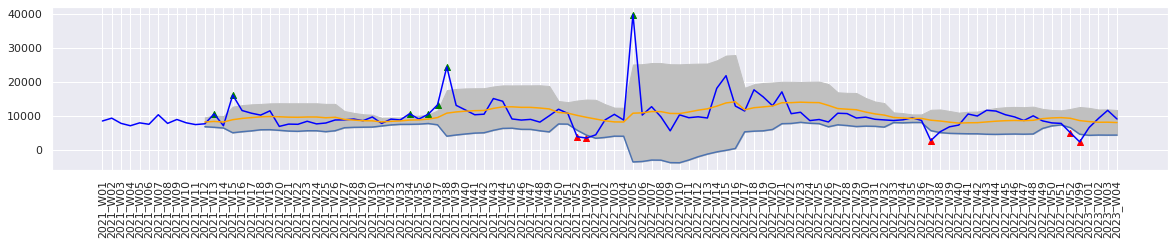

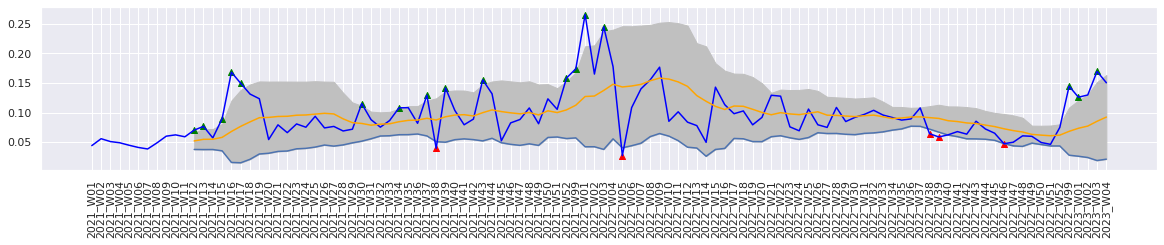

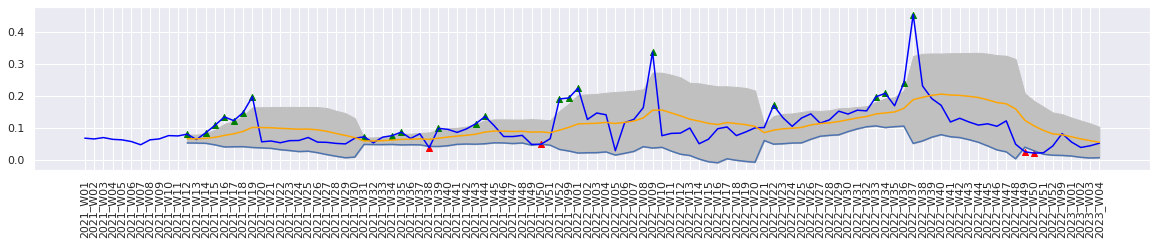

In [36]:
table = pd.pivot_table(data=top_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'mgmer_visitor', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Top Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else:  
    plt.title("MGMer Visitors - Top Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic43.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic43.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=top_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'referrer_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Top Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else: 
    plt.title("Referrer Rate - Top Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic42.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic42.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=top_mkt_df, values=['naa_rate'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'naa_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For NAA Rate - Top Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else: 
    plt.title("NAA Rate - Top Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic44.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic44.png', width=Inches(7), height=Inches(2))
    plt.show()

### Medium Markets Cross Hub

In [37]:
#document.add_heading(level=4).add_run('Medium Volume Driving Markets - CANADA,AUSTRALIA,JAPAN,MEXICO,GERMANY', style="Head")

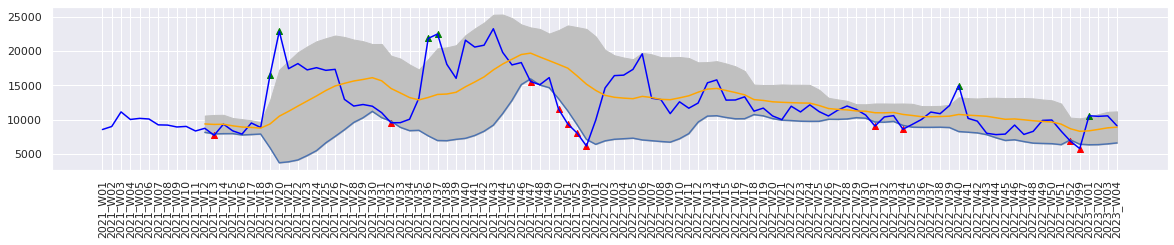

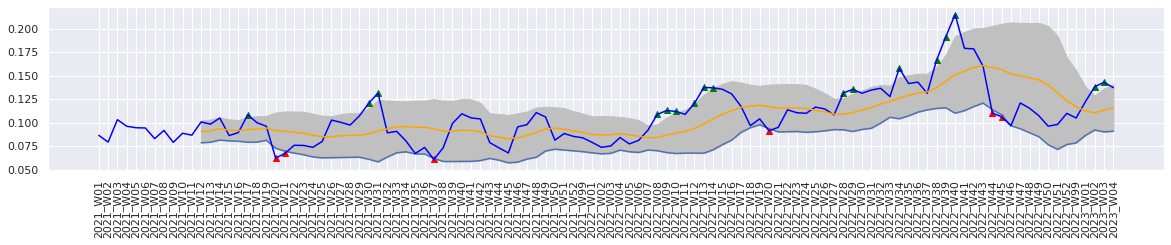

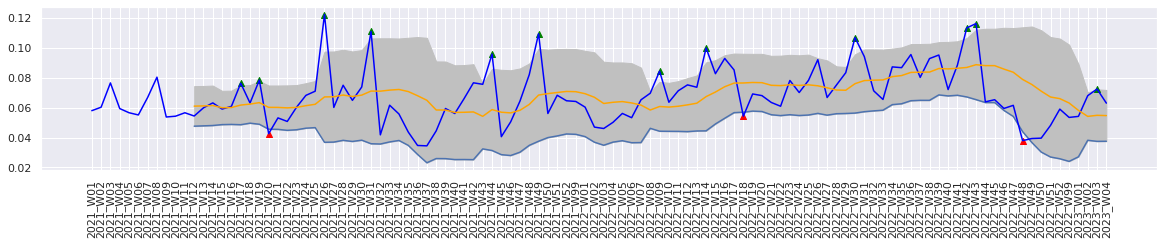

In [38]:
table = pd.pivot_table(data=mid_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Medium Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Medium Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic46.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic46.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=mid_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Medium Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Medium Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic45.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic45.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=mid_mkt_df, values=['naa_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Medium Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Medium Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic47.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic47.png', width=Inches(7), height=Inches(2))
    plt.show()

### Low Markets Cross Hub

In [39]:
#document.add_heading(level=4).add_run('Low Volume Driving Markets - ITALY,FRANCE,SWEDEN,NETHERLANDS,HONG KONG,SINGAPORE,SPAIN', style="Head")

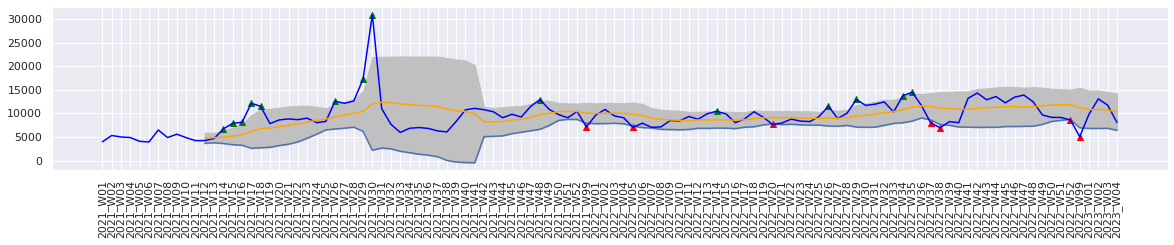

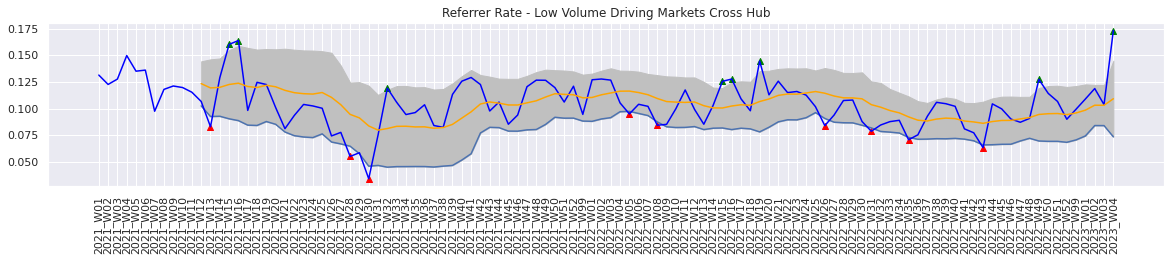

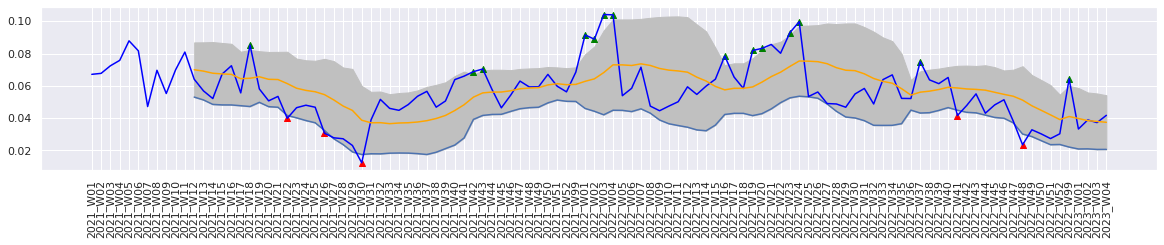

In [40]:
table = pd.pivot_table(data=low_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Low Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Low Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic49.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic49.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=low_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Low Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Low Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic48.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic48.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=low_mkt_df, values=['naa_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Low Volume Driving Markets Cross Hub, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Low Volume Driving Markets Cross Hub")
    plt.savefig(fileloc + 'pic50.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic50.png', width=Inches(7), height=Inches(2))
    plt.show()

### Mobile APP

In [41]:
mkt_df = overall_funnel_df.groupby(["year","week","market","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()
mkt_df = mkt_df[mkt_df['asset']=='APP']
mkt_df['referrer_rate'] =    mkt_df['referrer']/ mkt_df['mgmer_visitor']
mkt_df['naa_rate'] =  mkt_df['approved']/ mkt_df['mgmer_visits']

top_mkt_df = mkt_df[mkt_df['market']=='UK'].reset_index(drop=True)

mid_mkt_df = mkt_df[mkt_df.market.isin(['CANADA','AUSTRALIA','JAPAN','MEXICO','GERMANY'])].reset_index(drop=True)
mid_mkt_df = mid_mkt_df.groupby(["year","week","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

mid_mkt_df['referrer_rate'] =    mid_mkt_df['referrer']/ mid_mkt_df['mgmer_visitor']
mid_mkt_df['naa_rate'] =         mid_mkt_df['approved']/ mid_mkt_df['mgmer_visits']

low_mkt_df = mkt_df[mkt_df.market.isin(['ITALY','FRANCE','SWEDEN','NETHERLANDS','HONG KONG','SINGAPORE','SPAIN'])].reset_index(drop=True)
low_mkt_df = low_mkt_df.groupby(["year","week","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

low_mkt_df['referrer_rate'] =   low_mkt_df['referrer']/ low_mkt_df['mgmer_visitor']
low_mkt_df['naa_rate'] =        low_mkt_df['approved']/ low_mkt_df['mgmer_visits']

### Top Markets Cross Mobile APP

In [42]:
#document.add_heading(level=4).add_run('Top Volume Driving Market - UK', style="Head")

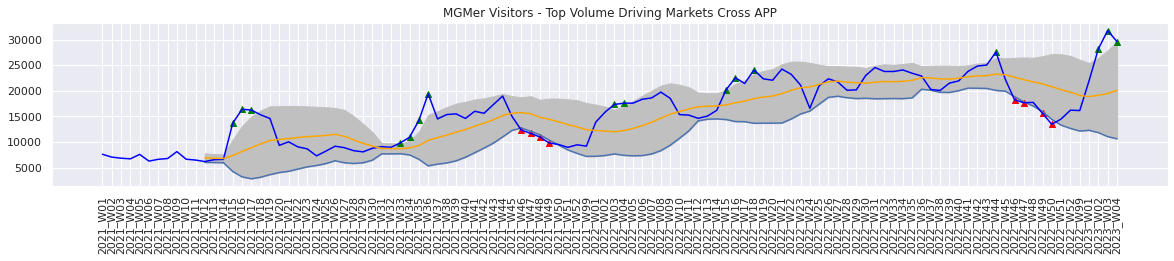

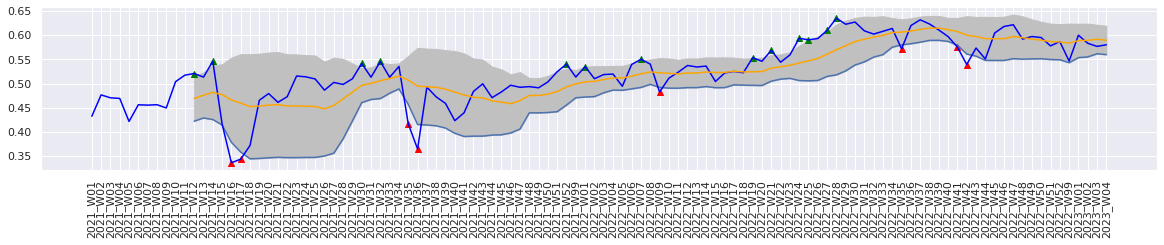

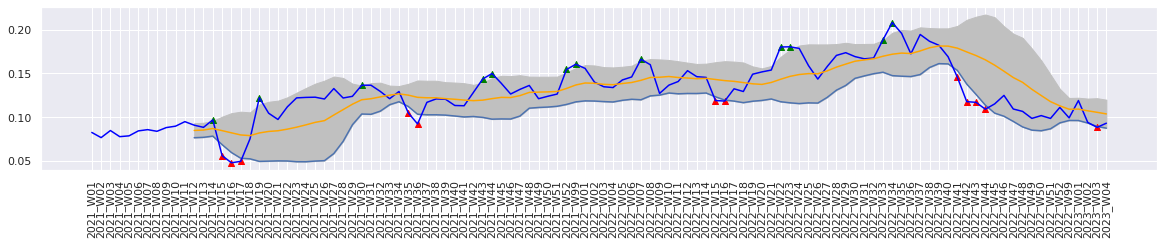

In [43]:
table = pd.pivot_table(data=top_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'mgmer_visitor', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Top Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:  
    plt.title("MGMer Visitors - Top Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic52.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic52.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=top_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'referrer_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Top Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:  
    plt.title("Referrer Rate - Top Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic51.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic51.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=top_mkt_df, values=['naa_rate'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'naa_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For NAA Rate - Top Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Top Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic53.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic53.png', width=Inches(7), height=Inches(2))
    plt.show()

### Medium Markets Cross Mobile APP

In [44]:
#document.add_heading(level=4).add_run('Medium Volume Driving Markets - CANADA,AUSTRALIA,JAPAN,MEXICO,GERMANY', style="Head")

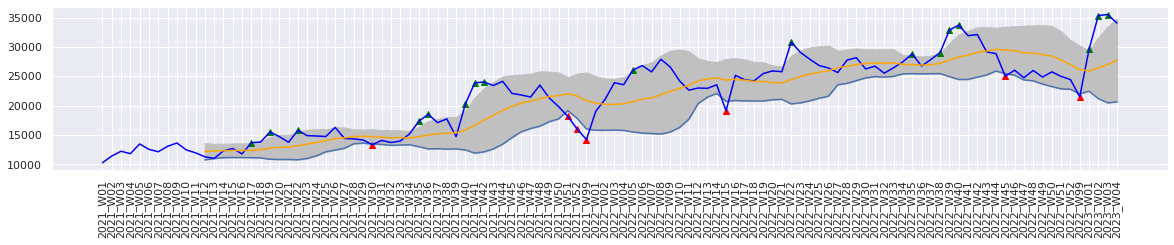

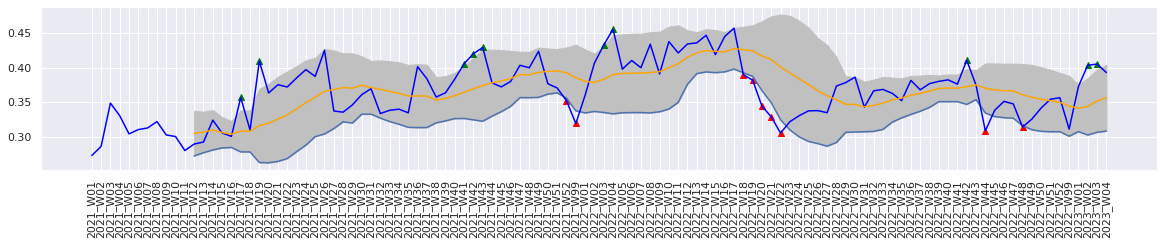

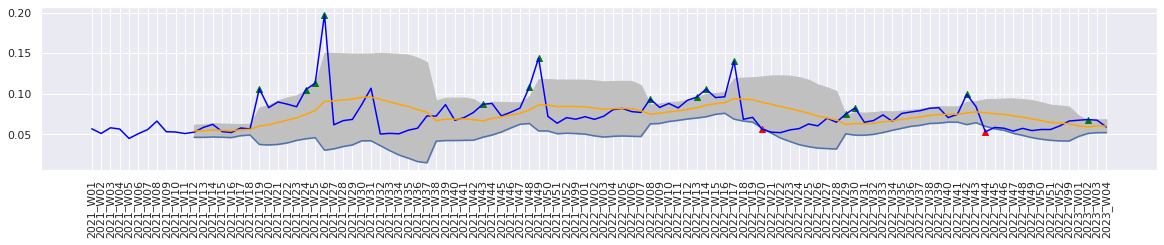

In [45]:
table = pd.pivot_table(data=mid_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Medium Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Medium Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic55.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic55.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=mid_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Medium Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Medium Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic54.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic54.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=mid_mkt_df, values=['naa_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Medium Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Medium Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic56.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic56.png', width=Inches(7), height=Inches(2))
    plt.show()

### Low Markets Cross Mobile APP

In [46]:
#document.add_heading(level=4).add_run('Low Volume Driving Markets - ITALY,FRANCE,SWEDEN,NETHERLANDS,HONG KONG,SINGAPORE,SPAIN', style="Head")

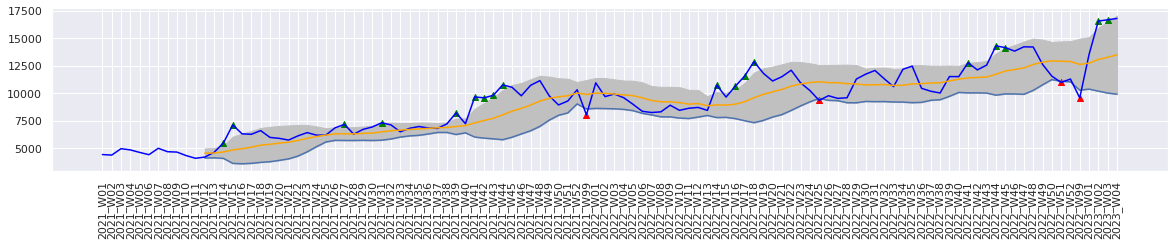

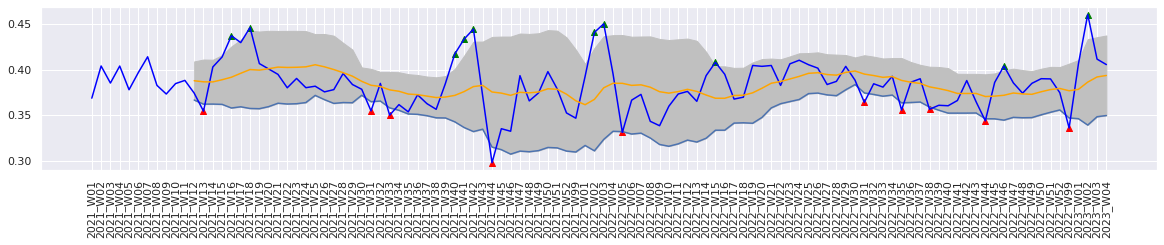

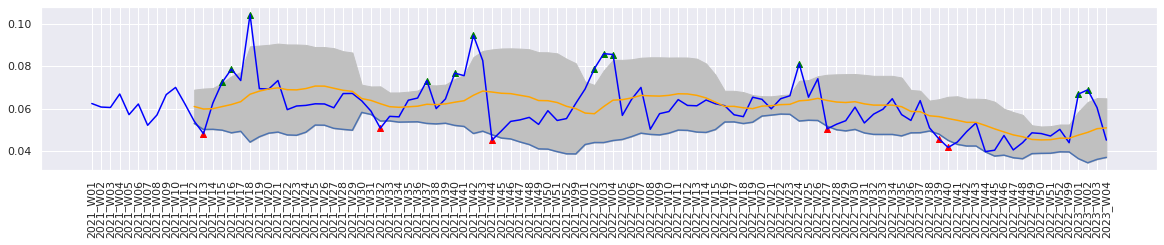

In [47]:
table = pd.pivot_table(data=low_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Low Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Low Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic58.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic58.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=low_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Low Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Low Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic57.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic57.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=low_mkt_df, values=['naa_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Low Volume Driving Markets Cross APP, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Low Volume Driving Markets Cross APP")
    plt.savefig(fileloc + 'pic59.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic59.png', width=Inches(7), height=Inches(2))
    plt.show()

### MYCA Widget

In [48]:
mkt_df = overall_funnel_df.groupby(["year","week","market","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()
mkt_df = mkt_df[mkt_df['asset']=='MYCA Widget']
mkt_df['referrer_rate'] =    mkt_df['referrer']/ mkt_df['mgmer_visitor']
mkt_df['naa_rate'] =  mkt_df['approved']/ mkt_df['mgmer_visits']

top_mkt_df = mkt_df[mkt_df['market']=='UK'].reset_index(drop=True)

mid_mkt_df = mkt_df[mkt_df.market.isin(['CANADA','AUSTRALIA','JAPAN','MEXICO','GERMANY'])].reset_index(drop=True)
mid_mkt_df = mid_mkt_df.groupby(["year","week","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

mid_mkt_df['referrer_rate'] =    mid_mkt_df['referrer']/ mid_mkt_df['mgmer_visitor']
mid_mkt_df['naa_rate'] =         mid_mkt_df['approved']/ mid_mkt_df['mgmer_visits']

low_mkt_df = mkt_df[mkt_df.market.isin(['ITALY','FRANCE','SWEDEN','NETHERLANDS','HONG KONG','SINGAPORE','SPAIN'])].reset_index(drop=True)
low_mkt_df = low_mkt_df.groupby(["year","week","asset"]).agg({'mgmer_visits':'sum',
                                                                            'mgmee_visitor':'sum',
                                                                            'approved':'sum',
                                                                            'mgmer_visitor':'sum',
                                                                            'referrer' : 'sum'}).reset_index()

low_mkt_df['referrer_rate'] =   low_mkt_df['referrer']/ low_mkt_df['mgmer_visitor']
low_mkt_df['naa_rate'] =        low_mkt_df['approved']/ low_mkt_df['mgmer_visits']

### Top Markets Cross MYCA Widget

In [49]:
#document.add_heading(level=4).add_run('Top Volume Driving Market - UK', style="Head")

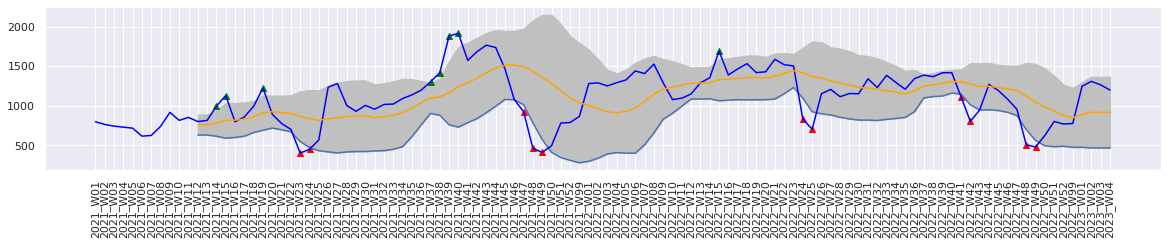

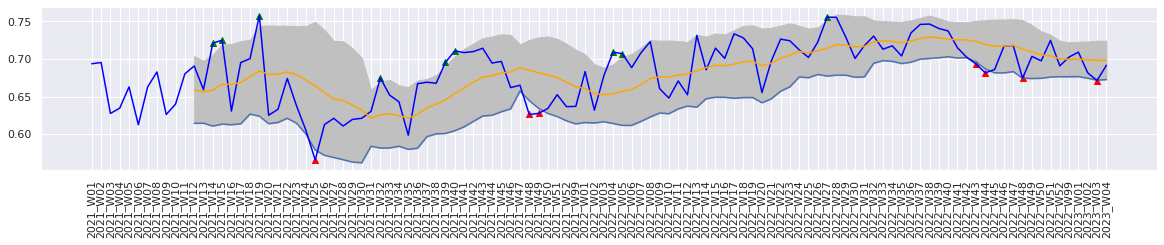

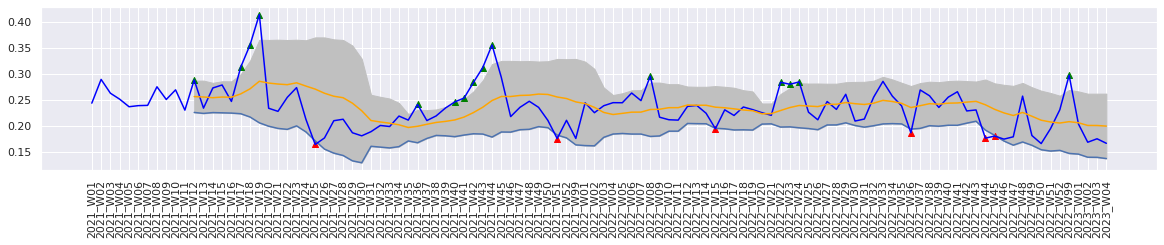

In [50]:
table = pd.pivot_table(data=top_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'mgmer_visitor', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Top Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:  
    plt.title("MGMer Visitors - Top Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic61.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic61.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=top_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'referrer_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Top Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:  
    plt.title("Referrer Rate - Top Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic60.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic60.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=top_mkt_df, values=['naa_rate'], index=['year','week',"asset"], columns=['market'], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,( 'naa_rate', 'UK'))
if np.isnan(table[-1:][(       'High',   '')][0]) and np.isnan(table[-1:][(       'Low',   '')][0]):
    doc_para = document.add_paragraph('For NAA Rate - Top Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:  
    plt.title("NAA Rate - Top Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic62.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic62.png', width=Inches(7), height=Inches(2))
    plt.show()

### Medium Markets Cross MYCA Widget

In [51]:
#document.add_heading(level=4).add_run('Medium Volume Driving Markets - CANADA,AUSTRALIA,JAPAN,MEXICO,GERMANY', style="Head")

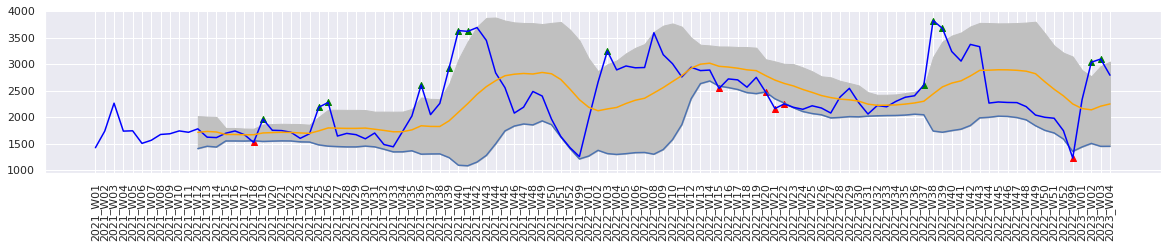

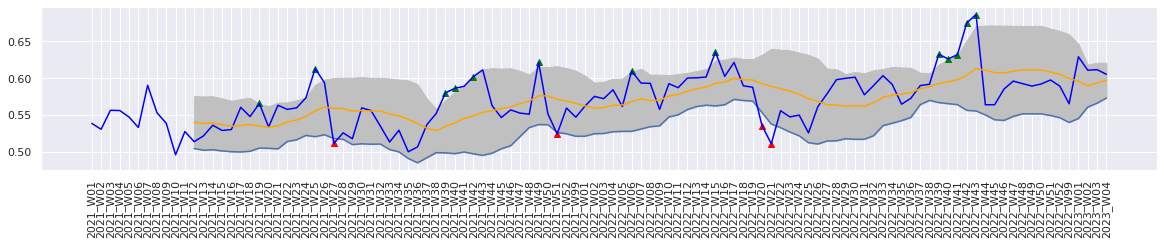

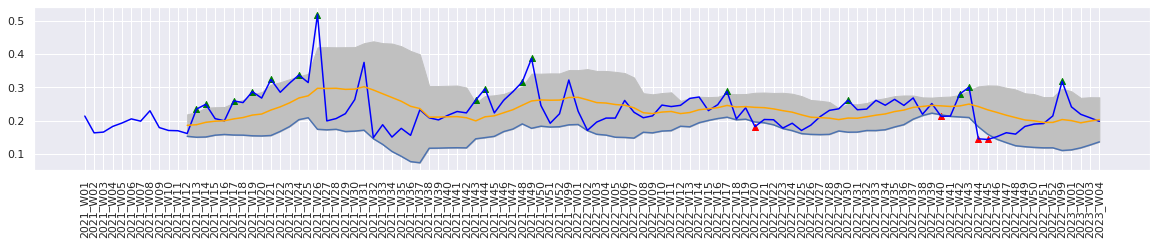

In [52]:
table = pd.pivot_table(data=mid_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Medium Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Medium Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic64.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic64.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=mid_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Medium Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Medium Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic63.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic63.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=mid_mkt_df, values=['naa_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Medium Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Medium Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic65.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic65.png', width=Inches(7), height=Inches(2))
    plt.show()

### Low Markets Cross MYCA Widget

In [53]:
#document.add_heading(level=4).add_run('Low Volume Driving Markets - ITALY,FRANCE,SWEDEN,NETHERLANDS,HONG KONG,SINGAPORE,SPAIN', style="Head")

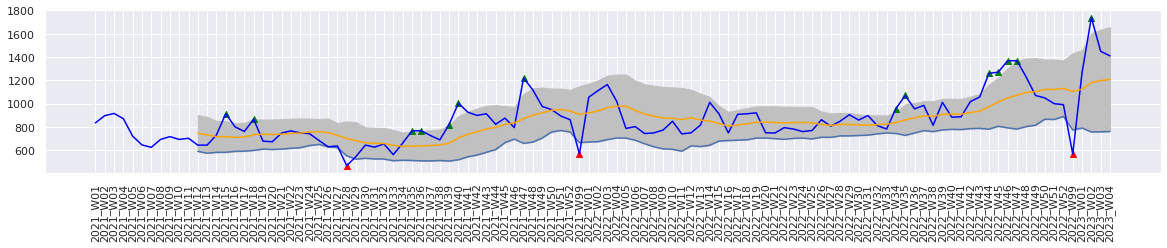

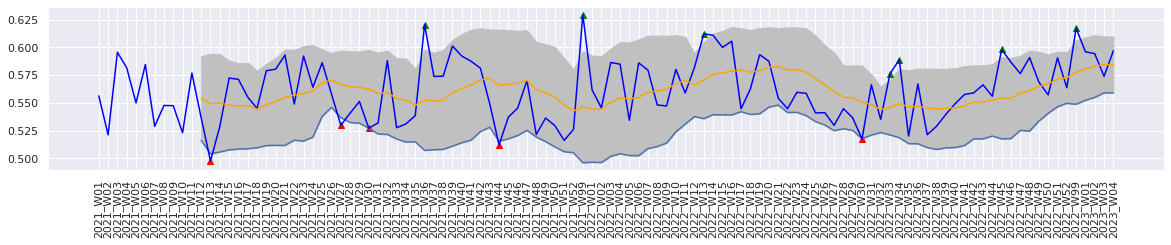

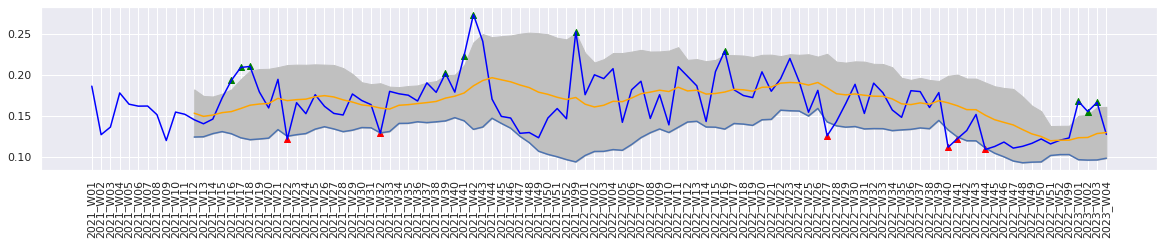

In [54]:
table = pd.pivot_table(data=low_mkt_df, values=['mgmer_visitor'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'mgmer_visitor')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For MGMer Visitors - Low Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("MGMer Visitors - Low Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic67.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic67.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=low_mkt_df, values=['referrer_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'referrer_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For Referrer Rate - Low Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("Referrer Rate - Low Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic66.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic66.png', width=Inches(7), height=Inches(2))
    plt.show()
table = pd.pivot_table(data=low_mkt_df, values=['naa_rate'], index=['year','week',"asset"], aggfunc='sum', fill_value=None, margins=False, dropna=True, margins_name='All', observed=False)
table = table.reset_index()
table,col= seg_func(table,'naa_rate')
if np.isnan(table[-1:]['High'][0]) and np.isnan(table[-1:]['Low'][0]):
    doc_para = document.add_paragraph('For NAA Rate - Low Volume Driving Markets Cross MYCA Widget, no anomalous behavior has been observed in the latest refresh.')
else:
    plt.title("NAA Rate - Low Volume Driving Markets Cross MYCA Widget")
    plt.savefig(fileloc + 'pic68.png', bbox_inches='tight')
    document.add_picture(fileloc + 'pic68.png', width=Inches(7), height=Inches(2))
    plt.show()

In [55]:
document.save(fileloc + filename)

In [56]:
EMAIL_REGEX = re.compile(r"[^@]+@[^@]+\.[^@]+")

def send_email(to, body=None, body_html=None, subject=None, reply_to="tanisha.sharma1@aexp.com",
               from_email='"{0}" <{1}>'.format('Tanisha Sharma', 'tanisha.sharma1@aexp.com'), files=()):
    if body is None and body_html is None:
        sys.exit(
            'Function send_email(), Argument `body` and `body_html`'
            ': Either one of `body` or `body_html` should be set')

    valid_to = []
    if isinstance(to, str):
         to = [to]
    for email_address in to:
        if not EMAIL_REGEX.match(email_address):
            sys.exit("Function send_email() Argument `to`: "
                     "Invalid email address got: {0} - ignoring this email.".format(email_address))
        elif not email_address.endswith("@aexp.com"):
            sys.exit("Function send_email() Argument `to`: "
                     "Cannot send emails outside @aexp.com - ignoring this email.")
        else:
            valid_to.append(email_address)
    if len(valid_to) == 0:
        sys.exit("Function send_email(): Found no valid emails to send the email to.")

    email_msg = MIMEMultipart('alternative')
    email_msg['From'] = from_email
    email_msg['To'] = ", ".join(valid_to)
    # email_msg['Date'] =
    email_msg['Subject'] = subject

    email_msg.add_header('reply-to', reply_to)

    if isinstance(files, str):
        files = [files]
    for f in files:
        with open(os.path.realpath(f), "rb") as fil:
            part = MIMEApplication(
                fil.read(),
                Name=os.path.basename(f)
            )
        # After the file is closed
        part['Content-Disposition'] = 'attachment; filename="{0}"'.format(os.path.basename(f))
        email_msg.attach(part)

    if body is not None:
        body = "NOTE: This is an automated email NOT sent by a human.\n" + body
        plain_body = MIMEText(body, 'plain')
        email_msg.attach(plain_body)
    if body_html is not None:
        body_html = "<p><b>This is an automated email NOT sent by a human</b><br />-------<br /><br /></p>" + body_html
        html_body = MIMEText(body_html, 'html')
        email_msg.attach(html_body)
    try:
        s = smtplib.SMTP('localhost')
    except ConnectionRefusedError as err:
        sys.exit("Function send_email(): Unable to connect to ")
    print("Sending the email:")
    print(email_msg.as_string())
    try:
        s.sendmail(email_msg['From'], valid_to, email_msg.as_string())
    except smtplib.SMTPException as err:
        errcode, errmsg = err
        sys.exit(
            "Function send_email(): Unable to send email. Error code: {0}. "
            "Error message: {0}".format(errcode, errmsg))
    finally:
        s.quit()

In [57]:
attach = (fileloc + filename)
body = '''
Greetings,

Please find attached, the output of Int'l MGM QC scripts.

Regards,
QC Script
'''

x= send_email(to=['Yashvi.Jain1@aexp.com','NISHKAM.VERMA@aexp.com','KANUPRIYA.BHARDWAJ@aexp.com','Ashna.Gupta@aexp.com','Tanisha.Sharma1@aexp.com'],
                   subject='Proactive Data Tracking Solution - QC Report', body= body, files=attach
                  )
#['Yashvi.Jain1@aexp.com','NISHKAM.VERMA@aexp.com','KANUPRIYA.BHARDWAJ@aexp.com','Ashna.Gupta@aexp.com','Tanisha.Sharma1@aexp.com']

Sending the email:
Content-Type: multipart/alternative; boundary="===============3678069934604450317=="
MIME-Version: 1.0
From: "Tanisha Sharma" <tanisha.sharma1@aexp.com>
To: Tanisha.Sharma1@aexp.com
Subject: QC Report
reply-to: tanisha.sharma1@aexp.com

--===============3678069934604450317==
Content-Type: application/octet-stream; Name="qc_report_trends1677039202.docx"
MIME-Version: 1.0
Content-Transfer-Encoding: base64
Content-Disposition: attachment; filename="qc_report_trends1677039202.docx"

UEsDBBQAAAAIAJGqVVb8p67QmwEAAPwGAAATAAAAW0NvbnRlbnRfVHlwZXNdLnhtbLWVT0/jMBDF
73yKKJccUOKyB4RWTTkscFyQKGKvrjNpDf4nzxTot2ccaITYsClbuESKZ957v7EVZ3r6ZE32ABG1
d3VxVE2KDJzyjXbLuriZX5QnRYYkXSONd1AXG8DidHYwnW8CYMZih3W+Igo/hUC1Aiux8gEcV1of
rSR+jUsRpLqXSxA/JpNjobwjcFRS8shn0zNo5dpQdv7Eyx1IfhdgmWe/XhpTVp1rmwy6ghjUBDcs
SevDiggG30lkCEYrSVwXD655N0v5OkfFyq4HVzrgITd8kJAqHwe86i55/6NuILuSkX5Ly11CrZG8
/WON0AT2KvqAR9W/3QZwfdtqBY1Xa8uSqjdNfhBJQ88+xMC6Llhwyt7ZkDalgaYMn8tWPsLnw7fn
lNQ7Jj762Iged99xkxvnKkDkT8maqq9Yqd0

# Data Checks 

In [52]:
prod_sbs = overall_funnel_df.loc[overall_funnel_df['product'].str.startswith('SBS', na=False)]
prod_sbs = prod_sbs[['year','week','market','prod_bu','product']]
prod_sbs['check1'] = np.where(prod_sbs['prod_bu']!='SBS',1,0)
check1_rows = prod_sbs[prod_sbs.check1==1]

a = prod_sbs['product'].value_counts()
b = prod_sbs['prod_bu'].value_counts()

if a.sum() == b.loc['SBS']:
    print("Check 1 Passed.")
    print("Product to BU mapping for SBS has been performed correctly")
else:
    print("Check 1 Failed.")
    print("Product to BU mapping for SBS has not been performed correctly")
    print("Affected rows:{}, {:.2f}%".format(check1_rows.shape[0], (check1_rows.shape[0]/prod_sbs.shape[0])*100))
    print("Printing Sample data...")
    display(check1_rows.head(5))

Check 1 Passed.
Product to BU mapping for SBS has been performed correctly


In [53]:
prod_cons = overall_funnel_df.loc[overall_funnel_df['product'].str.startswith('Cons', na=False)]
prod_cons = prod_cons[['year','week','market','prod_bu','product']]
prod_cons['check2'] = np.where(prod_cons['prod_bu']!='CONS',1,0)
check2_rows = prod_cons[prod_cons.check2==1]

c = prod_cons['product'].value_counts()
d = prod_cons['prod_bu'].value_counts()

if c.sum() == d.loc['CONS']:
    print("Check 2 Passed.")
    print("Product to BU mapping for CONS has been performed correctly")
else:
    print("Check 2 Failed.")
    print("Product to BU mapping for CONS has not been performed correctly")
    print("Affected rows:{}, {:.2f}%".format(check2_rows.shape[0], (check2_rows.shape[0]/prod_cons.shape[0])*100))
    print("Printing Sample data...")
    display(check2_rows.head(5))

Check 2 Passed.
Product to BU mapping for CONS has been performed correctly


In [54]:
overall_funnel_weekly = overall_funnel_df.groupby(['year','week']).agg({'mgmer_visitor':'sum','mgmer_visits':'sum','mgmee_visitor':'sum','mgmee_visits':'sum'}).reset_index()
overall_funnel_weekly['check3'] = np.where(overall_funnel_weekly['mgmer_visits']<overall_funnel_weekly['mgmer_visitor'],1,0)
overall_funnel_weekly['check4'] = np.where(overall_funnel_weekly['mgmee_visits']<overall_funnel_weekly['mgmee_visitor'],1,0)                                           

check3_rows = overall_funnel_weekly[overall_funnel_weekly.check3==1]

if check3_rows.shape[0] == 0 :
    print("Check 3 Passed.")
    print("For weekly aggregration, MGMer visits are always greater than MGMer visitors.")

else:
    print("Check 3 Failed.")
    print("For weekly aggregration, MGMer visits are not greater than MGMer visitors.")
    print("Affected rows:{}, {:.2f}%".format(check3_rows.shape[0], (check3_rows.shape[0]/overall_funnel_weekly.shape[0])*100))
    print("Printing Sample data...")
    display(check3_rows.head(5))

Check 3 Passed.
For weekly aggregration, MGMer visits are always greater than MGMer visitors.


In [55]:
check4_rows = overall_funnel_weekly[overall_funnel_weekly.check4==1]

if check4_rows.shape[0] == 0 :
    print("Check 4 Passed.")
    print("For weekly aggregration, MGMee visits are always greater than MGMee visitors.")

else:
    print("Check 4 Failed.")
    print("For weekly aggregration, MGMee visits are not greater than MGMee visitors.")
    print("Affected rows:{}, {:.2f}%".format(check4_rows.shape[0], (check4_rows.shape[0]/overall_funnel_weekly.shape[0])*100))
    print("Printing Sample data...")
    display(check4_rows.head(5))

Check 4 Failed.
For weekly aggregration, MGMee visits are not greater than MGMee visitors.
Affected rows:1, 1.75%
Printing Sample data...


,year,week,mgmer_visitor,mgmer_visits,mgmee_visitor,mgmee_visits,check3,check4
52,2022,W99,63784,65912,53865,8297,0,1


In [56]:
overall_funnel_check5 = overall_funnel_df.groupby(['year','week']).agg({'approved':'sum','decisioned':'sum'}).reset_index()
overall_funnel_check5['check5'] = np.where(overall_funnel_check5['decisioned']<overall_funnel_check5['approved'],1,0)

check5_rows = overall_funnel_check5[overall_funnel_check5.check5==1]

if check5_rows.shape[0] == 0 :
    print("Check 5 Passed.")
    print("For weekly aggregration, decisioned applications are always greater than approved applications.")

else:
    print("Check 5 Failed.")
    print("For weekly aggregration, decisioned applications are not greater than approved applications.")
    print("Affected rows:{}, {:.2f}%".format(check5_rows.shape[0], (check5_rows.shape[0]/overall_funnel_check5.shape[0])*100))
    print("Printing Sample data...")
    display(check5_rows.head(5))

Check 5 Failed.
For weekly aggregration, decisioned applications are not greater than approved applications.
Affected rows:1, 1.75%
Printing Sample data...


,year,week,approved,decisioned,check5
52,2022,W99,6559,1536,1


In [57]:
overall_funnel_check6 = overall_funnel_df.groupby(['year','week']).agg({'approved':'sum','submit':'sum'}).reset_index()
overall_funnel_check6['check6'] = np.where(overall_funnel_check6['submit']<overall_funnel_check6['approved'],1,0)

check6_rows = overall_funnel_check6[overall_funnel_check6.check6==1]

if check6_rows.shape[0] == 0 :
    print("Check 6 Passed.")
    print("For weekly aggregration, submits are always greater than approved applications.")

else:
    print("Check 6 Failed.")
    print("For weekly aggregration, submits are not greater than approved applications.")
    print("Affected rows:{}, {:.2f}%".format(check6_rows.shape[0], (check6_rows.shape[0]/overall_funnel_check6.shape[0])*100))
    print("Printing Sample data...")
    display(check6_rows.head(5))

Check 6 Failed.
For weekly aggregration, submits are not greater than approved applications.
Affected rows:1, 1.75%
Printing Sample data...


,year,week,approved,submit,check6
52,2022,W99,6559,1536,1


--------------------------------------------------------------------------------------------------------------------------

### END

In [22]:
#overall_funnel_df.columns
#
#mkt_df = overall_funnel_df.groupby(["year","week","market","prod_bu"]).agg({'referrer':'sum','mgmee_visitor':'sum','mgmer_visitor':'sum'}).reset_index()
#mkt_df = mkt_df[mkt_df['prod_bu']=='CONS']
##mkt_df['referrer_rate'] =    mkt_df['mgmer_referral_submit_total']/ mkt_df['mgmer_visitor']
##mkt_df['mgmee_per_mgmer'] =  mkt_df['mgmee_visitor']/ mkt_df['mgmer_visitor']
##mkt_df['appl_start_rate'] =  mkt_df['app_start']/ mkt_df['mgmee_visitor']
#
#top_mkt_df = mkt_df[mkt_df['market']=='UK'].reset_index(drop=True)
#
#top_mkt_df[top_mkt_df['week']=='W01']
#
#(18422/33846)*100
#
#(14776/26033)*100
#
#(4207/13059)*100